[DIY Disease Tracking Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash) (C) Fabrizio Smeraldi, 2020,2024 ([f.smeraldi@qmul.ac.uk](mailto:f.smeraldi@qmul.ac.uk) - [web](http://www.eecs.qmul.ac.uk/~fabri/)). This notebook is released under the [GNU GPLv3.0 or later](https://www.gnu.org/licenses/).

## COVID-19 Dashboard: Weekly Trends & Age Group Analysis

This dashboard presents up-to-date COVID-19 statistics for England, using both locally stored data and live data from the UK Health Security Agency (UKHSA).

It contains two visual sections:

Weekly Trends — Explore how cases, hospital admissions and deaths have changed over time.

Age Distribution — Compare COVID-19 impact across age groups for males, females or both.

The dashboard loads initial data from bundled JSON files.
You may then click Fetch Data to retrieve the latest available information from the official UKHSA API.
Both graphs update automatically after the refresh.

In [1]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import json

In [2]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

### Loading Initial Data

The dashboard uses two datasets:

- **Time Series Dataset** — daily values for three COVID-19 metrics.
- **Age Distribution Dataset** — case counts and rates separated by age group and sex. *Note: The age distribution data is not available through the UKHSA API and is only loaded from the local JSON file.*

These datasets are loaded from JSON files when the dashboard starts, ensuring the dashboard works even if the API is temporarily unavailable.


In [3]:
jsondata={}
# Load the time-series dataset
with open("timeseries.json", "r") as f:
    jsondata["timeseries"] = json.load(f)

# Load the age distribution dataset
with open("agedistribution.json", "r") as f:
    jsondata["agedistribution"] = json.load(f)

print("Initial data loaded successfully.")

Initial data loaded successfully.


## Data Processing

The dashboard processes the loaded data through two main functions:

1. **Time Series Processing** (`wrangle_timeseries`):
   - Converts date strings to datetime objects
   - Ensures numeric data types for metrics
   - Handles missing or malformed data

2. **Age Distribution Processing** (`wrangle_agedistribution`):
   - Aggregates data across all dates
   - Calculates average values and rates for each age group
   - Separates data by sex (male/female)
   - Sorts age groups numerically

The processed data is stored in two DataFrames:
- `df_timeseries`: Cleaned time series data
- `df_age`: Processed age distribution data

The code automatically handles data quality issues and provides warnings for missing or invalid data.

In [4]:
# WRANGLE TIME SERIES DATA

def wrangle_timeseries(rawdata):
    """
    rawdata: dictionary with key 'data' containing list of time series rows
    """
    df = pd.DataFrame(rawdata["data"])

    # Convert date column
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Convert numeric columns (auto-detect)
    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


# WRANGLE AGE DISTRIBUTION DATA

def wrangle_agedistribution(rawdata):
    """
    Processes age distribution data into a DataFrame.
    Aggregates data across all dates.
    """
    try:
        if not rawdata or "data" not in rawdata:
            print("Warning: No age distribution data available")
            return pd.DataFrame(columns=["age", "males_value", "females_value", "males_rate", "females_rate"])
            
        # Initialize dictionaries to store aggregated data
        age_data = {}
        
        for entry in rawdata["data"]:
            # Process males
            for male in entry.get("males", []):
                age = male.get("age")
                if not age:
                    continue
                    
                if age not in age_data:
                    age_data[age] = {
                        "males_value": 0,
                        "males_rate": 0,
                        "females_value": 0,
                        "females_rate": 0,
                        "male_count": 0,
                        "female_count": 0
                    }
                
                age_data[age]["males_value"] += float(male.get("value", 0))
                age_data[age]["males_rate"] += float(male.get("rate", 0))
                age_data[age]["male_count"] += 1
            
            # Process females
            for female in entry.get("females", []):
                age = female.get("age")
                if not age:
                    continue
                    
                if age not in age_data:
                    age_data[age] = {
                        "males_value": 0,
                        "males_rate": 0,
                        "females_value": 0,
                        "females_rate": 0,
                        "male_count": 0,
                        "female_count": 0
                    }
                
                age_data[age]["females_value"] += float(female.get("value", 0))
                age_data[age]["females_rate"] += float(female.get("rate", 0))
                age_data[age]["female_count"] += 1
        
        # Convert to list of rows
        rows = []
        for age, data in age_data.items():
            row = {"age": age}
            
            # Calculate averages for males
            if data["male_count"] > 0:
                row["males_value"] = data["males_value"] / data["male_count"]
                row["males_rate"] = data["males_rate"] / data["male_count"]
            else:
                row["males_value"] = 0
                row["males_rate"] = 0
                
            # Calculate averages for females
            if data["female_count"] > 0:
                row["females_value"] = data["females_value"] / data["female_count"]
                row["females_rate"] = data["females_rate"] / data["female_count"]
            else:
                row["females_value"] = 0
                row["females_rate"] = 0
                
            rows.append(row)
        
        # Create DataFrame and sort by age
        df = pd.DataFrame(rows)
        
        try:
            # convert to numeric for sorting
            df['age_num'] = pd.to_numeric(df['age'].str.replace('+', ''), errors='coerce')
            df = df.sort_values('age_num').drop('age_num', axis=1)
        except:
            # Fallback to string sort if conversion fails
            df = df.sort_values('age')
            
        return df.reset_index(drop=True)
        
    except Exception as e:
        print(f"Error processing age distribution data: {str(e)}")
        # Return empty DataFrame with expected columns
        return pd.DataFrame(columns=["age", "males_value", "females_value", "males_rate", "females_rate"])



# CALL WRANGLING FUNCTIONS

df_timeseries = wrangle_timeseries(jsondata["timeseries"])
df_age = wrangle_agedistribution(jsondata["agedistribution"])

print("Wrangling complete.")
df_timeseries.head(), df_age.head()


Wrangling complete.


(        date  cases  hospital  deaths
 0 2023-10-14   21.4       NaN     NaN
 1 2023-10-13   22.5       7.0     NaN
 2 2023-10-12   23.7       7.1     NaN
 3 2023-10-11   25.0       7.4     NaN
 4 2023-10-10   26.0       7.6     NaN,
         age    males_value    males_rate  females_value  females_rate
 0       90+   33890.485141  19988.727935   74526.731055  21201.338410
 1  15_to_19  362016.710253  22605.529569  425809.277117  28117.005423
 2  10_to_14  437616.838039  24838.147845  434958.211738  25987.746805
 3  60_to_64  229546.078752  14634.852080  259197.345468  15918.044577
 4  85_to_89   51561.771174  14476.242199   71403.482912  13493.716493)

## Refreshing the Dataset (Live UKHSA API)

Click **Update from API** to fetch the latest COVID-19 data from the official UKHSA API.

### How it Works:

1. **API Wrapper Class** (`APIwrapper`):
   - Manages API requests with rate limiting (max 3 requests/second)
   - Handles pagination for large datasets (up to 365 items per page)
   - Supports filtering and parameterization of requests

2. **Data Retrieval**:
   - Fetches time series data (cases, hospitalizations, deaths)
   - Note: Age distribution data is not updated via API (remains from local JSON)

3. **Error Handling**:
   - Gracefully handles API unavailability
   - Maintains existing data if update fails
   - Provides clear status messages

4. **Data Processing**:
   - Automatically converts and validates data
   - Updates visualizations with new data
   - Preserves data integrity throughout the process

The dashboard remains functional even if the API is unavailable, falling back to the last successfully loaded data.

In [5]:
import requests
import time

class APIwrapper:
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        self.count=None

    def get_page(self, filters={}, page_size=5):
        
        if page_size > 365:
            raise ValueError("Max supported page size is 365")
        
        if filters != self._filters or page_size != self._page_size:
            self._filters = filters
            self._page_size = page_size
            self._next_url = self._start_url
        
        if self._next_url == None:
            return []
        
        curr_time = time.time()
        deltat = curr_time - APIwrapper._last_access
        if deltat < 0.33: 
            time.sleep(0.33 - deltat)
        APIwrapper._last_access = curr_time
        
        parameters = {x: y for x, y in filters.items() if y != None}
        parameters["page_size"] = page_size
        
        response = requests.get(self._next_url, params=parameters).json()
        self._next_url = response["next"]
        self.count = response["count"]
        
        return response["results"]

    def get_all_pages(self, filters={}, page_size=365):
        """ Access the API and download all available data pages """
        data = []
        while True:
            next_page = self.get_page(filters, page_size)
            if next_page == []:
                break
            data.extend(next_page)
        return data


In [6]:
def access_api():
    try:
        base = {
            "theme": "infectious_disease",
            "sub_theme": "respiratory",
            "topic": "COVID-19",
            "geography_type": "Nation",
            "geography": "England"
        }

        # Show loading indicator
        print("Fetching data from UKHSA API...", end=" ")

        # Fetch data from API
        try:
            # 1. Rolling mean of case counts
            struct_cases = base.copy()
            struct_cases["metric"] = "COVID-19_cases_countRollingMean"
            api_cases = APIwrapper(**struct_cases)
            cases_data = api_cases.get_all_pages()

            # 2. Hospital occupied beds
            struct_hosp = base.copy()
            struct_hosp["metric"] = "COVID-19_healthcare_occupiedBedsByDay"
            api_hosp = APIwrapper(**struct_hosp)
            hosp_data = api_hosp.get_all_pages()

            # 3. Rolling mean of deaths
            struct_deaths = base.copy()
            struct_deaths["metric"] = "COVID-19_deaths_ONSRollingMean"
            api_deaths = APIwrapper(**struct_deaths)
            deaths_data = api_deaths.get_all_pages()

            # Merge into timeseries structure
            merged = []
            for c, h, d in zip(cases_data, hosp_data, deaths_data):
                merged.append({
                    "date": c.get("date"),
                    "cases": float(c.get("metric_value", 0)),
                    "hospital": float(h.get("metric_value", 0)),
                    "deaths": float(d.get("metric_value", 0))
                })

            print("✓ Data fetched successfully")
            return {
                "timeseries": {"data": merged},
                "agedistribution": {"data": []}  # Placeholder for age data
            }

        except Exception as e:
            print(f" Error fetching data: {str(e)}")
            return None

    except Exception as e:
        print(f" Unexpected error: {str(e)}")
        return None

In [7]:
def api_button_callback(button):
    """
    Callback for the API button.
    Fetches fresh data from the API and updates the graphs.
    Handles errors gracefully and provides user feedback.
    """
    with output:
        clear_output(wait=True)
        print("🔄 Fetching data from UKHSA API...", end=" ")
        
        try:
            # Fetch new data
            apidata = access_api()

            if apidata and "timeseries" in apidata:
                global df_timeseries, df_age
                
                try:
                    # Update time series
                    new_ts = wrangle_timeseries(apidata["timeseries"])
                    if not new_ts.empty:
                        df_timeseries = new_ts
                        print("✓ Time series updated", end=" ")
                    else:
                        print("⚠️ No time series data in API response", end=" ")
                    
                    # Update age distribution if available
                    if "agedistribution" in apidata and apidata["agedistribution"]:
                        new_age = wrangle_agedistribution(apidata["agedistribution"])
                        if not new_age.empty:
                            df_age = new_age
                            print("✓ Age distribution updated")
                        else:
                            print("⚠️ No valid age data in API response")
                            
                            # Fallback to local JSON if API fails
                            try:
                                with open('agedistribution.json', 'r') as f:
                                    age_data = json.load(f)
                                df_age = wrangle_agedistribution(age_data)
                                print("✓ Loaded age distribution from local file")
                            except Exception as e:
                                print(f"⚠️ Failed to load local age data: {str(e)}")
                    else:
                        print("⚠️ No age distribution in API response")
                    
                    # Only trigger the time series graph update
                    current = metric_selector.value
                    toggle = "cases" if current != "cases" else "hospital"
                    metric_selector.value = toggle
                    metric_selector.value = current
                    
                    print("✅ Data updated successfully!")
                    
                except Exception as e:
                    print(f"\nError processing API data: {str(e)}")
                    print("Using previously loaded data instead.")
                    
            else:
                print("\n No data received from API")
                print("Using previously loaded data instead.")
                
        except Exception as e:
            print(f"\n Failed to fetch data: {str(e)}")
            print("Using previously loaded data instead.")

# Create the API button
api_button = wdg.Button(
    description="Update from API",
    button_style='info',  # Makes the button blue
    icon='cloud-download'  # Adds a download icon
)

# Create the output area for displaying button status
output = wdg.Output()

# Call the callback function when the button is clicked
api_button.on_click(api_button_callback)

# Display the button and output area
display(api_button, output)

Button(button_style='info', description='Update from API', icon='cloud-download', style=ButtonStyle())

Output()

## Weekly COVID-19 Trends  
Use the dropdown menu to choose which COVID-19 metric to explore:

- **Cases**
- **Hospital Admissions**
- **Deaths**

The graph updates automatically based on selection, and it will also refresh if new data is downloaded from the API.


In [8]:
# GRAPH PLOTTING FUNCTION (REAL DATA)
def plot_timeseries(metric):
    global df_timeseries

    plt.figure(figsize=(10,5))

    if metric not in df_timeseries.columns:
        plt.text(0.5, 0.5, f"No data for {metric}", ha="center")
        plt.show()
        return

    df_timeseries.plot(x="date", y=metric, title=f"COVID-19 {metric.capitalize()} Over Time")
    plt.grid(True)
    plt.show()



# DROPDOWN WIDGET
metric_selector = wdg.Dropdown(
    options=['cases', 'hospital', 'deaths'],
    value='cases',
    description='Metric:',
    disabled=False,
)


# REFRESH GRAPH (used by API refresh button)

def refresh_graph():
    # Force redraw of timeseries
    current = metric_selector.value
    toggle = "cases" if current != "cases" else "hospital"
    metric_selector.value = toggle
    metric_selector.value = current

    # Force redraw of age distribution
    current_age = age_selector.value
    toggle_age = "Males" if current_age != "Males" else "Females"
    age_selector.value = toggle_age
    age_selector.value = current_age


# CONNECT WIDGET TO GRAPH
graph = wdg.interactive_output(
    plot_timeseries,
    {'metric': metric_selector}
)

display(metric_selector, graph)


Dropdown(description='Metric:', options=('cases', 'hospital', 'deaths'), value='cases')

Output()

HTML(value='\n<style>\n.widget-radio-box {\n    flex-wrap: nowrap !important;\n}\n.widget-radio-box label {\n …

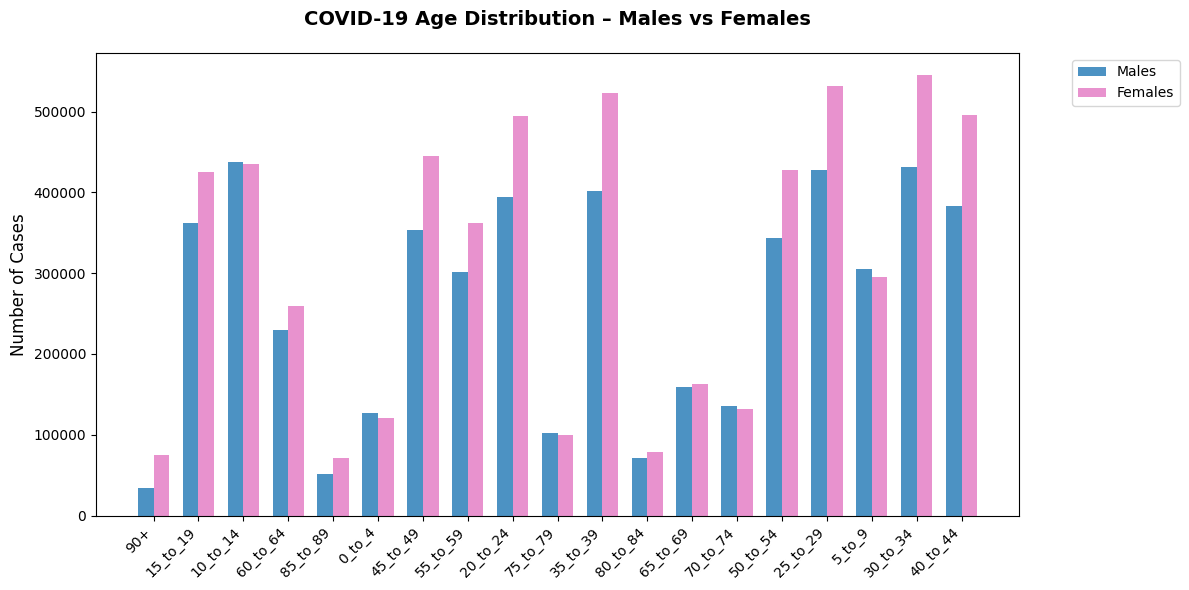

In [9]:
def plot_age_distribution(selected):
    """
    Plots age distribution for: Males, Females, or Both.
    Uses df_age created earlier from agedistribution.json.
    """
    plt.figure(figsize=(12, 6))
    
    # Check if required columns exist
    if 'age' not in df_age.columns or 'males_value' not in df_age.columns or 'females_value' not in df_age.columns:
        plt.text(0.5, 0.5, "Age distribution data not available", 
                ha="center", va="center", fontsize=12)
        plt.axis('off')
        plt.show()
        return
    
    # Define colors
    male_color = '#1f77b4'  # Blue
    female_color = '#e377c2'  # Pink
    
    if selected == "Males":
        plt.bar(df_age["age"], df_age["males_value"], 
               color=male_color, alpha=0.8, width=0.6)
        plt.title("COVID-19 Age Distribution – Males", pad=20, fontsize=14, fontweight='bold')
        plt.ylabel("Number of Cases", fontsize=12)
        
    elif selected == "Females":
        plt.bar(df_age["age"], df_age["females_value"], 
               color=female_color, alpha=0.8, width=0.6)
        plt.title("COVID-19 Age Distribution – Females", pad=20, fontsize=14, fontweight='bold')
        plt.ylabel("Number of Cases", fontsize=12)
        
    else:  # BOTH
        bar_width = 0.35
        x = range(len(df_age["age"]))
        
        plt.bar([i - bar_width/2 for i in x], df_age["males_value"], 
               width=bar_width, label="Males", color=male_color, alpha=0.8)
        plt.bar([i + bar_width/2 for i in x], df_age["females_value"], 
               width=bar_width, label="Females", color=female_color, alpha=0.8)
        
        plt.xticks(x, df_age["age"], rotation=45, ha='right')
        plt.title("COVID-19 Age Distribution – Males vs Females", 
                 pad=20, fontsize=14, fontweight='bold')
        plt.ylabel("Number of Cases", fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return  

    plt.xticks(range(len(df_age["age"])), df_age["age"], rotation=45, ha='right')
    plt.xlabel("Age Group", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#  Radio Buttons Widget
age_selector = wdg.RadioButtons(
    options=[
        ('Males', 'Males'),
        ('Females', 'Females'), 
        ('Compare Both', 'Both')
    ],
    value='Both',
    description='Show:',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '300px'}
)

#  CSS styling for the radio buttons
radio_style = """
<style>
.widget-radio-box {
    flex-wrap: nowrap !important;
}
.widget-radio-box label {
    margin-right: 15px !important;
    display: inline-flex !important;
    align-items: center;
}
</style>
"""
display(wdg.HTML(radio_style))

# CONNECT WIDGET TO AGE GRAPH
age_graph = wdg.interactive_output(
    plot_age_distribution,
    {'selected': age_selector}
)

# Display in a clean layout
display(
    wdg.VBox([
        wdg.HBox([age_selector]),
        age_graph
    ])
)